# Lab 1

## Part 2: Neural Machine Translation in the wild
In the second part of the homework you are supposed to get the best translation you can for the EN-RU translation task.

Basic approach using RNNs as encoder and decoder is implemented for you. 

Your ultimate task is to use the techniques we've covered, e.g.
* [Byte Pair Encoding](https://github.com/rsennrich/subword-nmt)

* CNN encoder (with or without positional encoding)

* attention/self-attention mechanism

* pretraining the language model

* or just fine-tunning BERT)

to improve the translation quality. 

__Please use at least three different approaches/models and compare them (translation quality/complexity/training and evaluation time).__
Write down some summary on your experiments and illustrate it with convergence plots/metrics and your thoughts. Just like you would approach a real problem.

In [0]:
! pip  install subword-nmt
! pip install nltk
! pip install torchtext==0.5.0
! pip install transformers
# ! wget https://raw.githubusercontent.com/ml-mipt/ml-mipt/advanced/homeworks/Lab1_NLP/data.txt

# Thanks to YSDA NLP course team for the data
# (who thanks tilda and deephack teams for the data in their turn)

     |████████████████████████████████| 81kB 3.7MB/s 
     |████████████████████████████████| 1.0MB 13.3MB/s 
  Found existing installation: torchtext 0.3.1
    Uninstalling torchtext-0.3.1:
      Successfully uninstalled torchtext-0.3.1


# Lab


In [0]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.datasets import TranslationDataset, Multi30k
from torchtext.data import Field, BucketIterator

import spacy

import random
import math
import time
import tqdm

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE

from nltk.translate.bleu_score import corpus_bleu

import networks

In [0]:
SEED = 1984

random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

### Preprocessing
__It's basic preprocessing just for following demonstration of several statistics of our corpus__


In [0]:
tokenizer_W = WordPunctTokenizer()
def tokenize(x, tokenizer=tokenizer_W):
    return tokenizer.tokenize(x.lower())

In [0]:
SRC = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

TRG = Field(tokenize="spacy",
            tokenizer_language="en",
            init_token = '<sos>', 
            eos_token = '<eos>',
            lower = True)

dataset = torchtext.data.TabularDataset(
    path='data.txt',
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)]
)

In [0]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])

# Body

In [0]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

In [0]:
SRC.build_vocab(train_data, min_freq = 3)
TRG.build_vocab(train_data, min_freq = 3)

In [0]:
print(f"Unique tokens in source (ru) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Here are tokens from original (RU) corpus:

In [0]:
SRC.vocab.itos[::1000]

And from target (EN) corpus:

In [0]:
TRG.vocab.itos[::1000]

And here is example from train dataset:

In [0]:
print(vars(train_data.examples[9]))

{'trg': ['at', 'aix', 'suite', 'location', 'you', 'will', 'find', 'a', 'garden', 'and', 'a', 'terrace', '.'], 'src': ['на', 'территории', 'здания', 'апартаментов', 'aix', 'suite', 'location', 'разбит', 'сад', 'и', 'обустроена', 'терраса', '.']}


Let's check the length distributions:

Length distribution in Train data


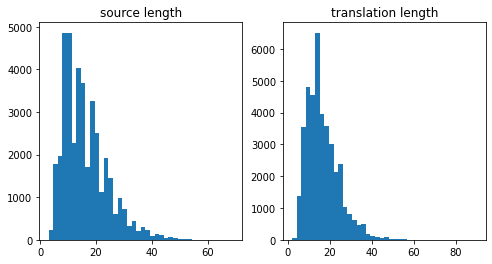

In [0]:
src_length = map(len, [vars(x)['src'] for x in train_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in train_data.examples])

print('Length distribution in Train data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=40);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=40);

Length distribution in Test data


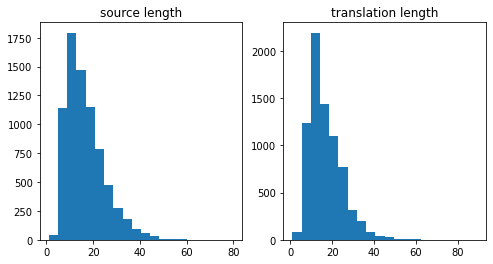

In [0]:
src_length = map(len, [vars(x)['src'] for x in test_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in test_data.examples])

print('Length distribution in Test data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

### Common Utils
__Useful functions, common for all approaches__

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [0]:
device

device(type='cuda')

In [0]:
def _len_sort_key(x):
    return len(x.src)

In [0]:
def init_weights(m):
    # <YOUR CODE HERE>
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)

In [0]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [0]:
def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()
    
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]
        
        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].view(-1)
        
        #trg = [(trg sent len - 1) * batch size]
        #output = [(trg sent len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        # Let's clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()

        
    return epoch_loss / len(iterator)

In [0]:
def train_cnn(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()
    
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output, _ = model(src, trg[:,:-1])
        
        #output = [batch size, trg len - 1, output dim]
        #trg = [batch size, trg len]
        
        output_dim = output.shape[-1]
        
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        # Let's clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()

        
    return epoch_loss / len(iterator)

In [0]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    history = []
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg sent len, batch size]
            #output = [trg sent len, batch size, output dim]

            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].view(-1)

            #trg = [(trg sent len - 1) * batch size]
            #output = [(trg sent len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [0]:
def evaluate_cnn(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    history = []
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output, _ = model(src, trg[:,:-1])
        
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]

            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)

            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [0]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [0]:
import utils
import imp
imp.reload(utils)
generate_translation = utils.generate_translation
remove_tech_tokens = utils.remove_tech_tokens
get_text = utils.get_text
flatten = utils.flatten

# Transformer ----- not as good as expected, but still ___>25 BLEU___

---



We will try to implement and then evalute performance of the most popular and powerful type of models right now - Transformers. As example of such models we will take ruBERT, implementation of BERT pretrained on russian corpora by guys from DeepPavlov and build up decoder for him. Structure of decoder follows concept from paper "Attention is all you need". On this model I had the most hopes, but... Unexpectedly, the result wasn't as good as I expected it to be. Maybe I was doing something wrong, but it still works and translates somehow. 
<br>
¯\\_(ツ)_/¯

### Utils
__Useful functions__

In [0]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [0]:
def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()
    
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        
        print("number of batch: ", i)
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output, _ = model(src, trg[:, :-1])
                
        #output = [batch size, trg len - 1, output dim]
        #trg = [batch size, trg len]
            
        output_dim = output.shape[-1]
            
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:, 1:].contiguous().view(-1)
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        # Let's clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()

        #scheduler.step()
        
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()

        
    return epoch_loss / len(iterator)

In [0]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output, _ = model(src, trg[:, :-1])
            
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]
            
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:, 1:].contiguous().view(-1)
            
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [0]:
def get_text(x, TRG_vocab):
    tech_idx = [TRG_vocab[x] for x in ['<sos>', '<unk>', '<pad>']]
    eos_idx = TRG_vocab['<eos>']
    text = []
    for idx in x:
        if idx in tech_idx:
            continue
        elif idx == eos_idx:
            break
        else:
            text.append(TRG_vocab.itos[idx])

    if len(text) < 1:
        text = []
    return text

In [0]:
def translate_sentence(src_indexes, TRG_vocab, model, device, max_len = MAX_LEN):
    
    model.eval()

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    
    src_mask = model.make_src_mask(src_tensor)
    
    with torch.no_grad():
        enc_src, _ = model.encoder(src_tensor, src_mask)

    trg_indexes = [TRG_vocab.vocab.stoi[TRG_vocab.init_token]]

    for i in range(max_len):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        trg_mask = model.make_trg_mask(trg_tensor)
        
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)

        pred_token = output.argmax(2)[:,-1].item()
        
        trg_indexes.append(pred_token)

        if pred_token == TRG_vocab.vocab.stoi[TRG_vocab.eos_token]:
            break
    
    trg_tokens = [TRG_vocab.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attention

In [0]:
def translate_sentence_batch(src_indexes, TRG_vocab, model, device, max_len = MAX_LEN):
    
    model.eval()

    batch_size = src_indexes.shape[0]

    src_tensor = src_indexes.to(device)
    
    src_mask = model.make_src_mask(src_tensor)
    
    with torch.no_grad():
        enc_src, _ = model.encoder(src_tensor, src_mask)

    trg_indexes = torch.LongTensor([TRG_vocab.vocab.stoi[TRG_vocab.init_token]]).unsqueeze(0).repeat(batch_size, 1).to(device)

    src_mask = src_mask.unsqueeze(1).unsqueeze(2)
    eos_mask = torch.tensor(False).unsqueeze(0).repeat(batch_size).to(device)

    for i in range(max_len):

        trg_mask = model.make_trg_mask(trg_indexes)
        
        with torch.no_grad():
            output, attention = model.decoder(trg_indexes, enc_src, trg_mask, src_mask)

        pred_token = output.argmax(2)[:,-1]
        pred_eos = (pred_token == TRG_vocab.vocab.stoi[TRG_vocab.eos_token])

        eos_mask = eos_mask | pred_eos
        if eos_mask.all():
            break
        
        trg_indexes = torch.cat((trg_indexes, pred_token.unsqueeze(1)), dim = 1)
    
    return trg_indexes[:, 1:]

### Transformer

In [0]:
from transformers import BertTokenizer, BertModel, BertConfig

tokenizer_ru = BertTokenizer.from_pretrained("DeepPavlov/rubert-base-cased")

In [0]:
pad_index_ru = tokenizer_ru.convert_tokens_to_ids(tokenizer_ru.pad_token)

SRC = Field(use_vocab=False,
            tokenize=tokenizer_ru.encode,
            pad_token=pad_index_ru,
            batch_first=True)

TRG = Field(tokenize="spacy",
            tokenizer_language="en",
            init_token = '<sos>', 
            eos_token = '<eos>',
            batch_first=True,
            lower = True)

dataset = torchtext.data.TabularDataset(
    path='data.txt',
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)]
)

In [0]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])
TRG.build_vocab(train_data, min_freq = 2)

In [0]:
bert_ru = BertModel.from_pretrained("DeepPavlov/rubert-base-cased",
                                    output_attentions = False,
                                    output_hidden_states = False)

In [0]:
for param in bert_ru.parameters():
    param.requires_grad = False

In [0]:
Seq2Seq = networks.Seq2SeqTransformer
Decoder = networks.DecoderTransformer

OUTPUT_DIM = len(TRG.vocab)
HID_DIM = 768
DEC_LAYERS = 3
DEC_HEADS = 8
DEC_PF_DIM = 1024
DEC_DROPOUT = 0.1
MAX_LEN = 150
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device,
              MAX_LEN)

In [0]:
dec.apply(initialize_weights)

Decoder(
  (tok_embedding): Embedding(10326, 768)
  (pos_embedding): Embedding(150, 768)
  (layers): ModuleList(
    (0): DecoderLayer(
      (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (self_attention): MultiHeadAttentionLayer(
        (fc_q): Linear(in_features=768, out_features=768, bias=True)
        (fc_k): Linear(in_features=768, out_features=768, bias=True)
        (fc_v): Linear(in_features=768, out_features=768, bias=True)
        (fc_o): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder_attention): MultiHeadAttentionLayer(
        (fc_q): Linear(in_features=768, out_features=768, bias=True)
        (fc_k): Linear(in_features=768, out_features=768, bias=True)
        (fc_v): Linear(in_features=768, out_features=768, bias=True)
        (fc_o): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (positionwise_fee

In [0]:
model = Seq2Seq(bert_ru, dec, pad_index_ru, TRG_PAD_IDX, device).to(device)

In [0]:
count_parameters(model)

34889046

In [0]:
BATCH_SIZE = 32

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key
)

In [0]:
from transformers.optimization import AdamW
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 10

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_iterator) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [0]:
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [0]:
train_history = []
valid_history = []

N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

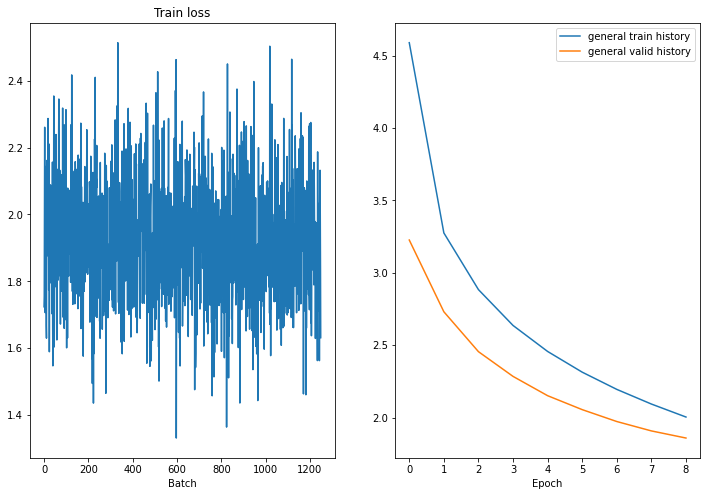

Epoch: 10 | Time: 8m 13s
	Train Loss: 1.926 | Train PPL:   6.860
	 Val. Loss: 1.811 |  Val. PPL:   6.117


In [0]:
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'bert_10_epochs_1984.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

__Again, let's take a look at our network quality__:

In [0]:
it = iter(valid_iterator)

In [0]:
batch = next(it)

In [0]:
example_idx = 103

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = [101, 40174, 13535, 29842, 13967, 6329, 6675, 845, 140, 4220, 1641, 36874, 9095, 11673, 10902, 10725, 851, 32283, 76611, 3359, 49116, 869, 72970, 6951, 2010, 69260, 845, 13309, 851, 80821, 3187, 869, 91319, 54800, 132, 102]
trg = ['just', '2', 'km', 'from', 'pelita', 'commercial', 'centre', ',', 'grand', 'palace', 'offers', 'spacious', 'rooms', 'with', 'flat', '-', 'screen', 'tvs', 'and', 'free', 'wired', 'internet', '.']


In [0]:
translation, attention = translate_sentence(src, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['just', '2', 'km', 'from', 'the', '<unk>', 'shopping', 'centre', ',', 'hotel', '<unk>', 'offers', 'spacious', 'rooms', 'with', 'free', 'wi', '-', 'fi', 'and', 'flat', '-', 'screen', 'tv', '.', '<eos>']


In [0]:
original_text = []
generated_text = []
model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output = translate_sentence_batch(src, TRG, model, device) #turn off teacher forcing
        
        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy()])
        generated_text.extend([get_text(x, TRG.vocab) for x in output.detach().cpu().numpy()])

# original_text = flatten(original_text)
# generated_text = flatten(generated_text)

235it [01:07,  3.46it/s]


In [0]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

25.809375012580304

# Baseline ----- ___12.16 BLEU___

Here comes simple pipeline of NMT model learning. It almost copies the week03 practice. I changed it a little bit, because BLEU score can be higher after the slight modification of the way translations are created. At the point where I still wasn't freezing the random seed, the results of this network varied from 11 to 14 BLEU but never higher. Even when I reworked translations, results only got up by approximately 1 BLEU.

### Utils
Useful functions, specific for this approach

In [0]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)

In [0]:
def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()
    
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]
        
        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].view(-1)
        
        #trg = [(trg sent len - 1) * batch size]
        #output = [(trg sent len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()

        
    return epoch_loss / len(iterator)

In [0]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    history = []
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg sent len, batch size]
            #output = [trg sent len, batch size, output dim]

            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].view(-1)

            #trg = [(trg sent len - 1) * batch size]
            #output = [(trg sent len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [0]:
def remove_tech_tokens(mystr, tokens_to_remove=['<eos>', '<sos>', '<unk>', '<pad>']):
    return [x for x in mystr if x not in tokens_to_remove]

def get_text(x, TRG_vocab):
    tech_idx = [TRG_vocab[x] for x in ['<sos>', '<unk>', '<pad>']]
    eos_idx = TRG_vocab['<eos>']
    text = []
    for idx in x:
        if idx in tech_idx:
            continue
        elif idx == eos_idx:
            break
        else:
            text.append(TRG_vocab.itos[idx])

    if len(text) < 1:
        text = []
    return text
    
def generate_translation(src, trg, model, TRG_vocab):
    model.eval()

    output = model(src, trg, 0) #turn off teacher forcing
    output = output.argmax(dim=-1).cpu().numpy()

    original = [TRG_vocab.itos[x] for x in list(trg[:,0].cpu().numpy())]
    generated = [TRG_vocab.itos[x] for x in list(output[:, 0])]
    
    original = remove_tech_tokens(original)
    generated = remove_tech_tokens(generated)[1:]
    print('Original: {}'.format(' '.join(original)))
    print('Generated: {}'.format(' '.join(generated)))
    print()

### Training and evaluating


In [0]:
SRC = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

TRG = Field(tokenize="spacy",
            tokenizer_language="en",
            init_token = '<sos>', 
            eos_token = '<eos>',
            lower = True)

dataset = torchtext.data.TabularDataset(
    path='data.txt',
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)]
)

In [0]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])
SRC.build_vocab(train_data, min_freq = 3)
TRG.build_vocab(train_data, min_freq = 3)

In [0]:
BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key
)

In [0]:
for x in train_iterator:
    break
print(x)
print(x.src.shape, x.trg.shape)


[torchtext.data.batch.Batch of size 128]
	[.trg]:[torch.cuda.LongTensor of size 55x128 (GPU 0)]
	[.src]:[torch.cuda.LongTensor of size 51x128 (GPU 0)]
torch.Size([51, 128]) torch.Size([55, 128])


In [0]:
Encoder = networks.EncoderBaseline
Decoder = networks.DecoderBaseline
Seq2Seq = networks.Seq2SeqBaseline

In [0]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

model = Seq2Seq(enc, dec, device).to(device)

In [0]:
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(9232, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(6836, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (out): Linear(in_features=512, out_features=6836, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [0]:
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 14,976,692 trainable parameters


In [0]:
PAD_IDX = TRG.vocab.stoi['<pad>']
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

In [0]:
train_history = []
valid_history = []

N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

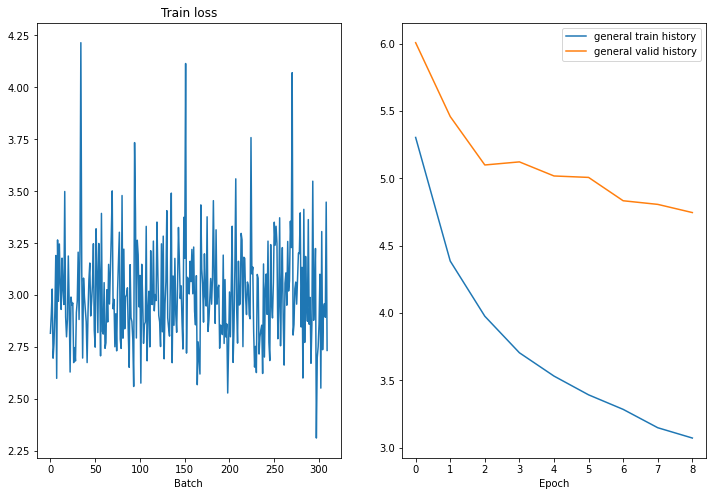

Epoch: 10 | Time: 1m 19s
	Train Loss: 3.007 | Train PPL:  20.227
	 Val. Loss: 4.769 |  Val. PPL: 117.753


In [0]:
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

__Let's take a look at our network quality__:

In [0]:
it = iter(test_iterator)

In [0]:
batch = next(it)

In [0]:
for idx in [1,2]:
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    generate_translation(src, trg, model, TRG.vocab)

Original: this property also features free wifi .
Generated: free wi - fi access is available .

Original: there is a 24-hour front desk at the property .
Generated: a 24-hour front desk and a bar . .



In [0]:
original_text = []
generated_text = []
model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output = model(src, trg, 0) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)

        #trim <sos> token
        output = output[1:, ...]
        
        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) for x in output.detach().cpu().numpy().T])

59it [00:04, 14.73it/s]


In [0]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

12.165625650303182

# Convolutional seq2seq ----- ___BEST VERSION, 33.73 BLEU !!!___

In this section results of training model of seq2seq convolution learning are located. There is also mechanism of attention added, its simplest realisation with `<pad>` tokens masked. The implementation of this network is the largest, but training isn't very time-consuming - 1 epoch takes only 1.5 minute. Since I didn't believe in networks with convolutional architecture, it was unexpected, but this model performs best - amazing result of 33.73 BLEU was achieved.


### Utils
Useful functions specific to this model

In [0]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)

In [0]:
def train_cnn(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()
    
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output, _ = model(src, trg[:,:-1])
        
        #output = [batch size, trg len - 1, output dim]
        #trg = [batch size, trg len]
        
        output_dim = output.shape[-1]
        
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        # Let's clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()

        
    return epoch_loss / len(iterator)

In [0]:
def evaluate_cnn(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    history = []
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output, _ = model(src, trg[:,:-1])
        
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]

            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)

            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [0]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [0]:
def remove_tech_tokens(mystr, tokens_to_remove=['<sos>', '<eos>', '<pad>', '<unk>']):
    return [x for x in mystr if x not in tokens_to_remove]

def get_text(x, TRG_vocab):
    tech_idx = [TRG_vocab[x] for x in ['<sos>', '<unk>', '<pad>']]
    eos_idx = TRG_vocab['<eos>']
    text = []
    for idx in x:
        if idx in tech_idx:
            continue
        elif idx == eos_idx:
            break
        else:
            text.append(TRG_vocab.itos[idx])

    if len(text) < 1:
        text = []
    return text

In [0]:
def translate_sentence(src_indexes, TRG_vocab, model, device, max_len = 150):
    
    model.eval()

    src_tensor = src_indexes.unsqueeze(0).to(device)
    
    src_mask = model.make_src_mask(src_tensor)
    
    with torch.no_grad():
        encoder_conved, encoder_combined = model.encoder(src_tensor)

    trg_indexes = [TRG_vocab.vocab.stoi[TRG_vocab.init_token]]

    for i in range(max_len):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)
        
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, encoder_conved, encoder_combined, src_mask)

        pred_token = output.argmax(2)[:,-1].item()
        
        if pred_token == TRG_vocab.vocab.stoi[TRG_vocab.eos_token]:
            break

        trg_indexes.append(pred_token)
    
    trg_tokens = [TRG_vocab.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:]

In [0]:
def translate_sentence_batch(src_indexes, TRG_vocab, model, device, max_len = 150):
    
    model.eval()

    batch_size = src_indexes.shape[0]

    src_tensor = src_indexes.to(device)
    
    src_mask = model.make_src_mask(src_tensor)
    
    with torch.no_grad():
        encoder_conved, encoder_combined = model.encoder(src_tensor)

    trg_indexes = torch.LongTensor([TRG_vocab.vocab.stoi[TRG_vocab.init_token]]).unsqueeze(0).repeat(batch_size, 1).to(device)

    eos_mask = torch.tensor(False).unsqueeze(0).repeat(batch_size).to(device)

    for i in range(max_len):
        
        with torch.no_grad():
            output, attention = model.decoder(trg_indexes, encoder_conved, encoder_combined, src_mask)

        pred_token = output.argmax(2)[:,-1]
        pred_eos = (pred_token == TRG_vocab.vocab.stoi[TRG_vocab.eos_token])

        eos_mask = eos_mask | pred_eos
        if eos_mask.all():
            break
        
        trg_indexes = torch.cat((trg_indexes, pred_token.unsqueeze(1)), dim = 1)
    
    return trg_indexes[:, 1:]

### Training and evaluating

Pipeline will be a bit defferent since in CNN it is common to set batch dimension first.

In [0]:
SRC = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>',
            batch_first=True, 
            lower = True)

TRG = Field(tokenize="spacy",
            tokenizer_language="en",
            init_token = '<sos>', 
            eos_token = '<eos>',
            batch_first=True,
            lower = True)

dataset = torchtext.data.TabularDataset(
    path='data.txt',
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)]
)

In [0]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])
SRC.build_vocab(train_data, min_freq = 3)
TRG.build_vocab(train_data, min_freq = 3)

In [0]:
BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key
)

In [0]:
Encoder = networks.EncoderCNN
Decoder = networks.DecoderCNN
Seq2Seq = networks.Seq2SeqCNN

In [0]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
EMB_DIM = 256
HID_DIM = 512 
ENC_LAYERS = 10 
DEC_LAYERS = 10 
ENC_KERNEL_SIZE = 3 
DEC_KERNEL_SIZE = 3 
ENC_DROPOUT = 0.25
DEC_DROPOUT = 0.25
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]
    
enc = Encoder(INPUT_DIM, EMB_DIM, HID_DIM, ENC_LAYERS, ENC_KERNEL_SIZE, ENC_DROPOUT, device, 150)
dec = Decoder(OUTPUT_DIM, EMB_DIM, HID_DIM, DEC_LAYERS, DEC_KERNEL_SIZE, DEC_DROPOUT, TRG_PAD_IDX, device, 150)

model = Seq2Seq(enc, dec, TRG_PAD_IDX).to(device)

In [0]:
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 38,213,556 trainable parameters


In [0]:
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (tok_embedding): Embedding(9232, 256)
    (pos_embedding): Embedding(150, 256)
    (emb2hid): Linear(in_features=256, out_features=512, bias=True)
    (hid2emb): Linear(in_features=512, out_features=256, bias=True)
    (convs): ModuleList(
      (0): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (2): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (3): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (4): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (5): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (6): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (7): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (8): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (9): Conv1d(512, 1024, kernel_size=(3,), stride=(1,),

In [0]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [0]:
train_history = []
valid_history = []

N_EPOCHS = 10
CLIP = 0.1

best_valid_loss = float('inf')

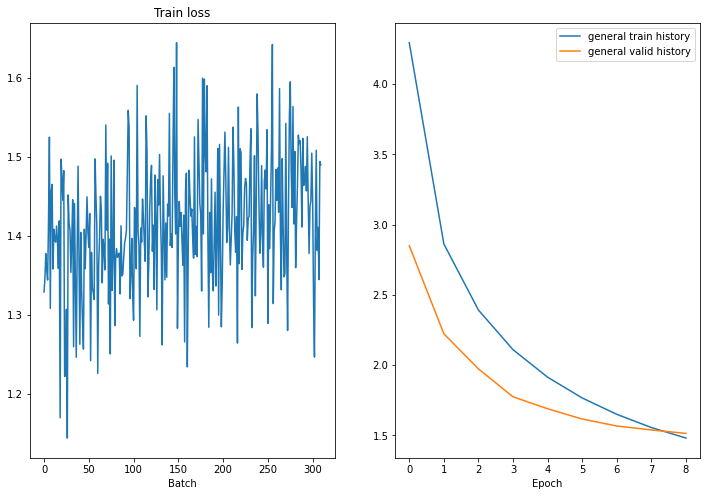

Epoch: 10 | Time: 1m 28s
	Train Loss: 1.415 | Train PPL:   4.116
	 Val. Loss: 1.486 |  Val. PPL:   4.417


In [0]:
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train_cnn(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate_cnn(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'cnn_encoder.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

__Again, let's take a look at our network quality__:

In [0]:
it = iter(test_iterator)

In [0]:
batch = next(it)

In [0]:
example_idx = 103

src = batch.src[example_idx:example_idx+1, :].squeeze()
trg = batch.trg[example_idx:example_idx+1, :].squeeze()

src_sent = get_text(src, SRC.vocab)
trg_sent = get_text(trg, TRG.vocab)

print(f'src = {src_sent}')
print(f'trg = {trg_sent}')

src = ['предоставляются', 'гладильные', 'принадлежности', '.']
trg = ['ironing', 'facilities', 'are', 'available', '.']


In [0]:
translation = translate_sentence(src, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['ironing', 'facilities', 'are', 'available', '.']


In [0]:
original_text = []
generated_text = []
model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output = translate_sentence_batch(src, TRG, model, device)
        
        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy()])
        generated_text.extend([get_text(x, TRG.vocab) for x in output.detach().cpu().numpy()])

59it [00:38,  1.52it/s]


In [0]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

33.73211458420787

# Attention(not "self-" kind, simple kind) ----- ___28 BLEU(!!!)___

This is baseline model with biLSTM as RNN encoder and LSTM as RNN decoder, to which attention was added. The increase in performance was shocking compared to baseline - results jumped 15 points higher!

### Utils
Useful functions, specific for this approach

In [0]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)

In [0]:
def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()
    
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]
        
        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].view(-1)
        
        #trg = [(trg sent len - 1) * batch size]
        #output = [(trg sent len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        # Let's clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()

        
    return epoch_loss / len(iterator)

In [0]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    history = []
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg sent len, batch size]
            #output = [trg sent len, batch size, output dim]

            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].view(-1)

            #trg = [(trg sent len - 1) * batch size]
            #output = [(trg sent len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [0]:
def remove_tech_tokens(mystr, tokens_to_remove=['<eos>', '<sos>', '<unk>', '<pad>']):
    return [x for x in mystr if x not in tokens_to_remove]

def get_text(x, TRG_vocab):
    tech_idx = [TRG_vocab[x] for x in ['<sos>', '<unk>', '<pad>']]
    eos_idx = TRG_vocab['<eos>']
    text = []
    for idx in x:
        if idx in tech_idx:
            continue
        elif idx == eos_idx:
            break
        else:
            text.append(TRG_vocab.itos[idx])

    if len(text) < 1:
        text = []
    return text
    
def generate_translation(src, trg, model, TRG_vocab):
    model.eval()

    output = model(src, trg, 0) #turn off teacher forcing
    output = output.argmax(dim=-1).cpu().numpy()

    original = [TRG_vocab.itos[x] for x in list(trg[:,0].cpu().numpy())]
    generated = [TRG_vocab.itos[x] for x in list(output[:, 0])]
    
    original = remove_tech_tokens(original)
    generated = remove_tech_tokens(generated)[1:]
    print('Original: {}'.format(' '.join(original)))
    print('Generated: {}'.format(' '.join(generated)))
    print()

### Training and evaluating


In [0]:
SRC = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

TRG = Field(tokenize="spacy",
            tokenizer_language="en",
            init_token = '<sos>', 
            eos_token = '<eos>',
            lower = True)

dataset = torchtext.data.TabularDataset(
    path='data.txt',
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)]
)

In [0]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])
SRC.build_vocab(train_data, min_freq = 3)
TRG.build_vocab(train_data, min_freq = 3)

In [0]:
BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key
)

In [0]:
Encoder = networks.Encoder
Attention = networks.SimpleAttention
Decoder = networks.DecoderSimpleAttention
Seq2Seq = networks.Seq2SeqSimpleAttention

In [0]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ATTN_DIM = 64
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)

attn = Attention(ENC_HID_DIM, DEC_HID_DIM, ATTN_DIM)

dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

model = Seq2Seq(enc, dec, device).to(device)

In [0]:
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(9232, 256)
    (rnn): LSTM(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn_W): Linear(in_features=1536, out_features=64, bias=True)
    )
    (embedding): Embedding(6836, 256)
    (rnn): LSTM(1280, 512)
    (out): Linear(in_features=1792, out_features=6836, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [0]:
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 23,821,620 trainable parameters


In [0]:
PAD_IDX = TRG.vocab.stoi['<pad>']
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

In [0]:
train_history = []
valid_history = []

N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

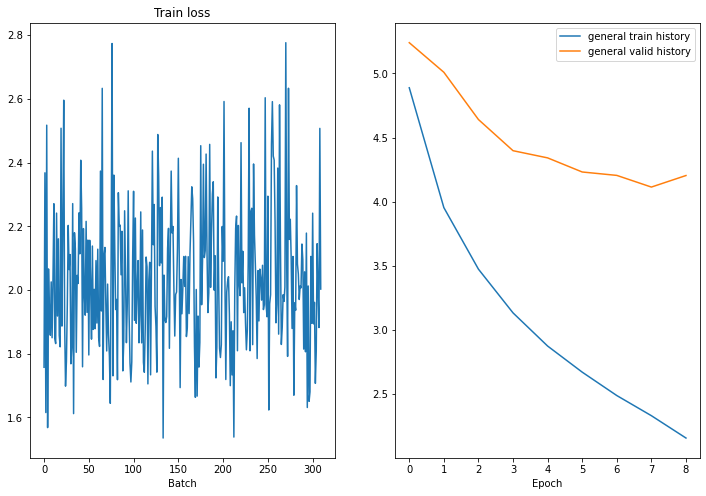

Epoch: 10 | Time: 6m 58s
	Train Loss: 2.035 | Train PPL:   7.654
	 Val. Loss: 4.222 |  Val. PPL:  68.154


In [0]:
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'attention_lstm.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

__Again, let's take a look at our network quality__:

In [0]:
it = iter(test_iterator)

In [0]:
batch = next(it)

In [0]:
for idx in [1,2]:
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    generate_translation(src, trg, model, TRG.vocab)

In [0]:
original_text = []
generated_text = []
model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output = model(src, trg, 0) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)
        
        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) for x in output.detach().cpu().numpy().T])

59it [00:05, 11.38it/s]


In [0]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

27.999794363905394

# Attention(simple kind, upgraded version) ----- ___27.24 BLEU___

The history of this model is quite strange. When I still wasn't freezing random seed, it showed great result, 1-2 points better than simple attention. But when I finally freezed seed and reworked mechanism of translation, it suddenly started performing the same if not worse. Still, the result is not half bad. This is the variant of seq2seq with attention which makes use of `nn.utils.rnn.pack_padded_sequence`, and corrects model by applying mask with zeros corresponding positions of `<pad>` tokens in input. Our iterator now have to give us `src_len` as well, so we change pipeline a little bit.

### Utils
Useful functions, specific for this approach

In [0]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)

In [0]:
def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None, scheduler=None):
    model.train()
    
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        
        src, src_len = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output = model(src, src_len, trg)
        
        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]
        
        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].view(-1)
        
        #trg = [(trg sent len - 1) * batch size]
        #output = [(trg sent len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()

        if scheduler:
          scheduler.step()
        
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()

        
    return epoch_loss / len(iterator)

In [0]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    history = []
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src, src_len = batch.src
            trg = batch.trg

            output = model(src, src_len, trg, 0)

            #trg = [trg sent len, batch size]
            #output = [trg sent len, batch size, output dim]

            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].view(-1)

            #trg = [(trg sent len - 1) * batch size]
            #output = [(trg sent len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [0]:
def remove_tech_tokens(mystr, tokens_to_remove=['<eos>', '<sos>', '<unk>', '<pad>']):
    return [x for x in mystr if x not in tokens_to_remove]

def get_text(x, TRG_vocab):
    tech_idx = [TRG_vocab[x] for x in ['<sos>', '<unk>', '<pad>']]
    eos_idx = TRG_vocab['<eos>']
    text = []
    for idx in x:
        if idx in tech_idx:
            continue
        elif idx == eos_idx:
            break
        else:
            text.append(TRG_vocab.itos[idx])

    if len(text) < 1:
        text = []
    return text
    
def generate_translation(src, src_len, trg, model, TRG_vocab):
    model.eval()

    output = model(src, src_len, trg, 0) #turn off teacher forcing
    output = output.argmax(dim=-1).cpu().numpy()

    original = [TRG_vocab.itos[x] for x in list(trg[:,0].cpu().numpy())]
    generated = [TRG_vocab.itos[x] for x in list(output[:, 0])]
    
    original = remove_tech_tokens(original)
    generated = remove_tech_tokens(generated)[1:]
    print('Original: {}'.format(' '.join(original)))
    print('Generated: {}'.format(' '.join(generated)))
    print()

### Attention, masked biLSTM, additive score


In [0]:
SRC = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            include_lengths = True,
            lower = True)

TRG = Field(tokenize="spacy",
            tokenizer_language="en",
            init_token = '<sos>', 
            eos_token = '<eos>',
            lower = True)

dataset = torchtext.data.TabularDataset(
    path='data.txt',
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)]
)

In [0]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])
SRC.build_vocab(train_data, min_freq = 3)
TRG.build_vocab(train_data, min_freq = 3)

In [0]:
Encoder = networks.EncoderPaddedAttention
Attention = networks.PaddedAttention
Decoder = networks.DecoderPaddedAttention
Seq2Seq = networks.Seq2SeqPaddedAttention

In [0]:
BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
     batch_size = BATCH_SIZE,
     sort_within_batch = True,
     sort_key = _len_sort_key,
     device = device)

In [0]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ATTN_DIM = 64
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)

attn = Attention(ENC_HID_DIM, DEC_HID_DIM, ATTN_DIM)

dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

model = Seq2Seq(enc, dec, device, SRC_PAD_IDX).to(device)

In [0]:
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(9232, 256)
    (rnn): LSTM(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn_W): Linear(in_features=1536, out_features=64, bias=True)
      (attn_v): Linear(in_features=64, out_features=1, bias=False)
    )
    (embedding): Embedding(6836, 256)
    (rnn): LSTM(1280, 512)
    (out): Linear(in_features=1792, out_features=6836, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [0]:
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 23,821,620 trainable parameters


In [0]:
optimizer = optim.Adam(model.parameters())

In [0]:
PAD_IDX = TRG.vocab.stoi['<pad>']
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

In [0]:
train_history = []
valid_history = []

CLIP = 1
N_EPOCHS = 10

best_valid_loss = float('inf')

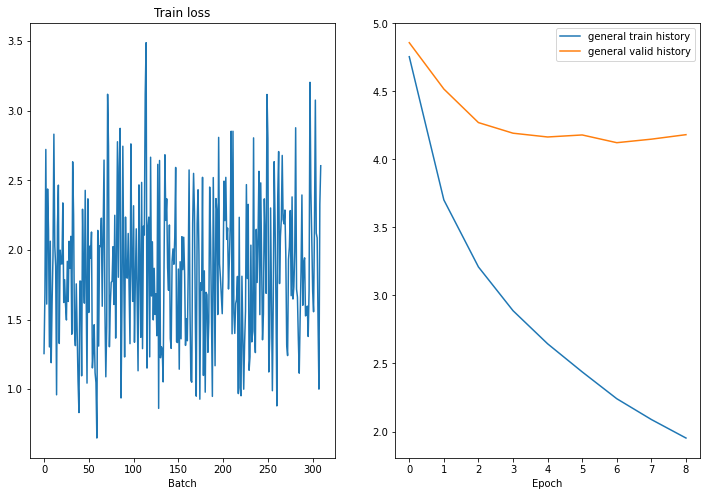

Epoch: 10 | Time: 1m 11s
	Train Loss: 1.841 | Train PPL:   6.301
	 Val. Loss: 4.160 |  Val. PPL:  64.097


In [0]:
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion,
                       CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'attention_lstm_padded.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

__Again, let's take a look at our network quality__:

In [0]:
it = iter(test_iterator)

In [0]:
batch = next(it)

In [0]:
for idx in range(10):
    src = batch.src[0][:, idx:idx+1]
    src_len = batch.src[1][idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    generate_translation(src, src_len, trg, model, TRG.vocab)

Original: you will find a 24-hour front desk at the property .
Generated: you will find a 24-hour front desk at the property .

Original: this property also features free wifi .
Generated: free wifi access is available . . .

Original: there is a 24-hour front desk at the property .
Generated: you will find a 24-hour front desk at the property .

Original: hairdryers can be requested .
Generated: a hairdryer are available upon request . .

Original: you will find a 24-hour front desk at the property .
Generated: you will find a 24-hour front desk at the property .

Original: you will find a 24-hour front desk at the property .
Generated: there is a 24-hour front desk at the property . .

Original: guests enjoy free parking .
Generated: the property offers free parking . .

Original: free private parking is available .
Generated: free private parking is available on site .

Original: the property offers free parking .
Generated: the property offers free parking . .

Original: the proper

In [0]:
original_text = []
generated_text = []
model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src, src_len = batch.src
        trg = batch.trg

        output = model(src, src_len, trg, 0) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)

        output = output[1:, ...]
        
        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) for x in output.detach().cpu().numpy().T])

59it [00:05, 11.30it/s]


In [0]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

27.246698344955966

# Thoughts

Let's write down some thoughts about work that has been done and personal discoveries that were made in process.
<br>
<br>
First of all, it is very important to freeze the random seed when you do things on not very large datasets -- during several retrainings results from my padded LSTM varied from 17 to 24 BLEU, and this was not only scary until I had understood what is a problem, it was also very inconvenient for comparing different architectures. What's more, not freezing seed deprives us of ability to save and load weigths, because our models contain dimensions based on size of vocab from train dataset, which is not constant!
<br>
<br>
Second, it is substantial to write suitable functions for translating our sentences when evaluating. BLEU score is sensitive to length of unnecessary characters, and just by trimming all garbage after first appearance of `<eos>` we can get 2-3% additional BLEU, and the same goes to trimming `<sos>`.
<br>
<br>
Third, you always should understand the way your model generates translations. I lost many time on CNN and Transformers because of this.
<br>
<br>
On final choice of models... I still not quite believe in results achieved with CNN. It's definitely good but I can't trust it. On the other hand, I think that there is something that I could've done with BERT to make it translate better. There was an option in `transformers` library to make from BERT, or any other transformer a decoder, but I didn't quite get it how to use it, so I decided to make simple decoder.
<br>
<br>
Also, I don't understand why my model with the simplest attention takes so long to train - 6 minutes on epoch compared to 1 and half minute on epoch in Attention upgraded version.
<br>
<br>
Plots are very similar to each other, but only within two groups - CNN and Transformer on one hand, and models with rnns on the other. This happens because of different way of evaluation in first type of modes - this may be a bit confusing but still helps. Many models in RNNs tend to overfit by the end of 10 epochs but since we use only model with highest validation score it's no big problem.